In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jet-quark-gluon/quark-gluon_data-set_n139306.hdf5


In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.neighbors import NearestNeighbors

plt.style.use('ggplot')

In [4]:
file_path = '/kaggle/input/jet-quark-gluon/quark-gluon_data-set_n139306.hdf5'

# Load all data from HDF5 file
with h5py.File(file_path, 'r') as f:
    print("Available keys in the HDF5 file:")
    print(list(f.keys()))
    
    print("\nDataset shapes:")
    print(f"X_jets shape: {f['X_jets'].shape}")
    print(f"y shape: {f['y'].shape}")

Available keys in the HDF5 file:
['X_jets', 'm0', 'pt', 'y']

Dataset shapes:
X_jets shape: (139306, 125, 125, 3)
y shape: (139306,)


In [ ]:
def sample_from_hdf5(file_path, n_samples=100000, random_seed=42):
    np.random.seed(random_seed)
    with h5py.File(file_path, 'r') as f:
        total_samples = f['X_jets'].shape[0]
        indices = np.random.choice(total_samples, size=n_samples, replace=False)
        indices.sort() 
        
        # Initialize arrays
        X_sample = np.empty((n_samples, 125, 125, 3), dtype=np.float32)
        y_sample = np.empty(n_samples, dtype=np.int8)
        
        # Read in chunks
        chunk_size = 2000
        for i in range(0, n_samples, chunk_size):
            chunk_indices = indices[i:i+chunk_size]
            X_sample[i:i+chunk_size] = f['X_jets'][chunk_indices]
            y_sample[i:i+chunk_size] = f['y'][chunk_indices]
            
    return X_sample, y_sample

X_sample, y_sample = sample_from_hdf5(file_path, n_samples=20000)
print(f"\nSampled data shapes:")
print(f"X_sample: {X_sample.shape}")
print(f"y_sample: {y_sample.shape}")
print(f"Class distribution: {np.unique(y_sample, return_counts=True)}")


Sampled data shapes:
X_sample: (20000, 125, 125, 3)
y_sample: (20000,)
Class distribution: (array([0, 1], dtype=int8), array([10087,  9913]))


In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("\nFinal split sizes:")
print(f"Train: {X_train.shape[0]} samples ")
print(f"Validation: {X_val.shape[0]} samples ")
print(f"Test: {X_test.shape[0]} samples ")
print(f"\nClass distribution in Train: {np.unique(y_train, return_counts=True)}")
print(f"Class distribution in Val: {np.unique(y_val, return_counts=True)}")
print(f"Class distribution in Test: {np.unique(y_test, return_counts=True)}")


Final split sizes:
Train: 16000 samples 
Validation: 2000 samples 
Test: 2000 samples 

Class distribution in Train: (array([0, 1], dtype=int8), array([8070, 7930]))
Class distribution in Val: (array([0, 1], dtype=int8), array([1008,  992]))
Class distribution in Test: (array([0, 1], dtype=int8), array([1009,  991]))


In [ ]:

class JetGraphDataset(Dataset):
    def __init__(self, images, labels, k=4):
        self.images = images
        self.labels = labels
        self.k = k
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        try:
            img = self.images[idx]
            label = int(self.labels[idx])
            non_zero_indices = np.argwhere(np.any(img != 0, axis=-1))
            
            if non_zero_indices.shape[0] == 0:
                non_zero_indices = np.array([[0, 0]])
                pixel_values = np.array([[0.0, 0.0, 0.0]])
            else:
                pixel_values = img[non_zero_indices[:, 0], non_zero_indices[:, 1]]
            
            coords = non_zero_indices / np.array([img.shape[0], img.shape[1]])
            features = np.concatenate([coords, pixel_values], axis=1).astype(np.float32)
            x = torch.tensor(features, dtype=torch.float)
            
            if x.size(0) > 1:
                nbrs = NearestNeighbors(n_neighbors=min(self.k+1, x.size(0)), algorithm='auto').fit(x[:, :2].numpy())
                distances, indices = nbrs.kneighbors(x[:, :2].numpy())
                src_list = []
                dst_list = []
                for i in range(x.size(0)):
                    for j in indices[i][1:]:
                        src_list.append(i)
                        dst_list.append(j)
                edge_index = torch.tensor([src_list, dst_list], dtype=torch.long)
            else:
                edge_index = torch.empty((2, 0), dtype=torch.long)
            
            data = Data(x=x, edge_index=edge_index, y=torch.tensor([label], dtype=torch.long))
            return data
        except Exception as e:
            print(f"Error processing index {idx}: {e}")
            dummy_x = torch.zeros((1, 5), dtype=torch.float)
            dummy_edge_index = torch.empty((2, 0), dtype=torch.long)
            return Data(x=dummy_x, edge_index=dummy_edge_index, y=torch.tensor([0], dtype=torch.long))

train_dataset = JetGraphDataset(X_train, y_train, k=4)
val_dataset = JetGraphDataset(X_val, y_val, k=4)
test_dataset = JetGraphDataset(X_test, y_test, k=4)

In [ ]:
train_loader = GeoDataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = GeoDataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = GeoDataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class JetGNN(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64, num_classes=2):
        super(JetGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.relu(self.conv1(x, edge_index))
        x = self.relu(self.conv2(x, edge_index))
        x = self.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)  # Aggregate node features to obtain graph-level representation
        x = self.fc(x)
        return x

model = JetGNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [10]:

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_dataset)

def evaluate(loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item() * data.num_graphs
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.num_graphs
    return total_loss / len(loader.dataset), correct / total

In [11]:
num_epochs = 50
train_losses = []
val_losses = []
val_accs = []
best_val_acc = 0.0
epochs_no_improve = 0
early_stop_patience = 20

for epoch in range(1, num_epochs + 1):
    train_loss = train()
    val_loss, val_acc = evaluate(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch: {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    if epochs_no_improve >= early_stop_patience:
        print("Early stopping triggered")
        break

Epoch: 01, Train Loss: 0.6932, Val Loss: 0.6930, Val Acc: 0.5025
Epoch: 02, Train Loss: 0.6929, Val Loss: 0.6928, Val Acc: 0.5090
Epoch: 03, Train Loss: 0.6926, Val Loss: 0.6929, Val Acc: 0.5075
Epoch: 04, Train Loss: 0.6917, Val Loss: 0.6915, Val Acc: 0.5130
Epoch: 05, Train Loss: 0.6641, Val Loss: 0.6338, Val Acc: 0.6795
Epoch: 06, Train Loss: 0.6210, Val Loss: 0.6100, Val Acc: 0.6800
Epoch: 07, Train Loss: 0.6129, Val Loss: 0.6022, Val Acc: 0.6805
Epoch: 08, Train Loss: 0.6092, Val Loss: 0.6007, Val Acc: 0.6935
Epoch: 09, Train Loss: 0.6086, Val Loss: 0.6003, Val Acc: 0.6795
Epoch: 10, Train Loss: 0.6080, Val Loss: 0.6005, Val Acc: 0.6775
Epoch: 11, Train Loss: 0.6073, Val Loss: 0.6062, Val Acc: 0.6915
Epoch: 12, Train Loss: 0.6067, Val Loss: 0.5959, Val Acc: 0.6870
Epoch: 13, Train Loss: 0.6044, Val Loss: 0.5977, Val Acc: 0.6875
Epoch: 14, Train Loss: 0.6048, Val Loss: 0.5953, Val Acc: 0.6905
Epoch: 15, Train Loss: 0.6034, Val Loss: 0.5981, Val Acc: 0.6845
Epoch: 16, Train Loss: 0.

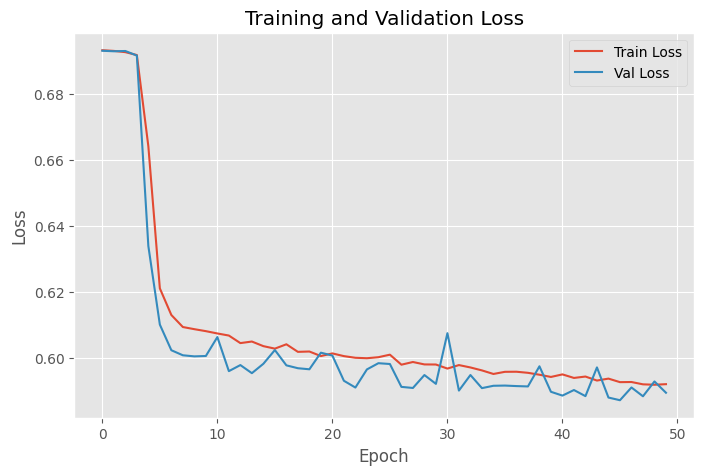

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

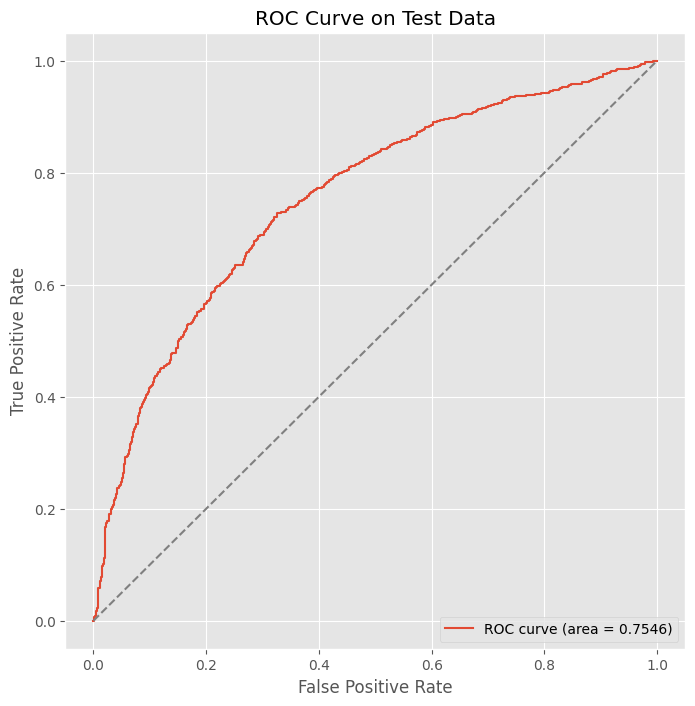

In [13]:
model.eval()
all_labels = []
all_probs = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        probs = torch.softmax(out, dim=1)[:, 1]
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Test Data")
plt.legend(loc="lower right")
plt.show()

In [15]:
class BatchedNonLocalBlock(nn.Module):
    def __init__(self, in_channels, inter_channels=None):
        super(BatchedNonLocalBlock, self).__init__()
        if inter_channels is None:
            inter_channels = in_channels // 2
        self.theta = nn.Linear(in_channels, inter_channels)
        self.phi = nn.Linear(in_channels, inter_channels)
        self.g = nn.Linear(in_channels, inter_channels)
        self.out = nn.Linear(inter_channels, in_channels)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x, batch):
        out = torch.zeros_like(x)
        for b in torch.unique(batch):
            mask = (batch == b)
            x_b = x[mask]
            if x_b.size(0) == 0:
                continue
            theta_x = self.theta(x_b)
            phi_x = self.phi(x_b)
            g_x = self.g(x_b)
            f = torch.matmul(theta_x, phi_x.t())
            f_div_C = self.softmax(f)
            y = torch.matmul(f_div_C, g_x)
            y = self.out(y)
            out[mask] = x_b + y  # Residual connection
        return out

In [ ]:
class NonLocalJetGNN(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64, num_classes=2):
        super(NonLocalJetGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.non_local = BatchedNonLocalBlock(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.relu(self.conv1(x, edge_index))
        x = self.non_local(x, batch)
        x = self.relu(self.conv2(x, edge_index))
        x = self.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nonlocal_model = NonLocalJetGNN().to(device)
optimizer_nonlocal = optim.Adam(nonlocal_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [17]:
def train_nonlocal():
    nonlocal_model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer_nonlocal.zero_grad()
        out = nonlocal_model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer_nonlocal.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_dataset)

def evaluate_nonlocal(loader):
    nonlocal_model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = nonlocal_model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item() * data.num_graphs
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.num_graphs
    return total_loss / len(loader.dataset), correct / total


In [18]:
num_epochs = 50
nonlocal_train_losses = []
nonlocal_val_losses = []
nonlocal_val_accs = []
best_val_acc_nonlocal = 0.0
epochs_no_improve_nonlocal = 0
early_stop_patience = 20

for epoch in range(1, num_epochs + 1):
    train_loss = train_nonlocal()
    val_loss, val_acc = evaluate_nonlocal(val_loader)
    nonlocal_train_losses.append(train_loss)
    nonlocal_val_losses.append(val_loss)
    nonlocal_val_accs.append(val_acc)
    print(f"[Non-local] Epoch: {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc_nonlocal:
        best_val_acc_nonlocal = val_acc
        epochs_no_improve_nonlocal = 0
    else:
        epochs_no_improve_nonlocal += 1
    if epochs_no_improve_nonlocal >= early_stop_patience:
        print("[Non-local] Early stopping triggered")
        break


[Non-local] Epoch: 01, Train Loss: 0.6935, Val Loss: 0.6931, Val Acc: 0.5040
[Non-local] Epoch: 02, Train Loss: 0.6932, Val Loss: 0.6931, Val Acc: 0.5040
[Non-local] Epoch: 03, Train Loss: 0.6932, Val Loss: 0.6932, Val Acc: 0.4980
[Non-local] Epoch: 04, Train Loss: 0.6930, Val Loss: 0.6930, Val Acc: 0.5060
[Non-local] Epoch: 05, Train Loss: 0.6932, Val Loss: 0.6927, Val Acc: 0.5180
[Non-local] Epoch: 06, Train Loss: 0.6919, Val Loss: 0.6902, Val Acc: 0.5255
[Non-local] Epoch: 07, Train Loss: 0.6227, Val Loss: 0.5986, Val Acc: 0.7035
[Non-local] Epoch: 08, Train Loss: 0.6020, Val Loss: 0.5974, Val Acc: 0.7000
[Non-local] Epoch: 09, Train Loss: 0.5994, Val Loss: 0.5938, Val Acc: 0.6980
[Non-local] Epoch: 10, Train Loss: 0.5974, Val Loss: 0.5929, Val Acc: 0.7015
[Non-local] Epoch: 11, Train Loss: 0.5959, Val Loss: 0.5832, Val Acc: 0.7015
[Non-local] Epoch: 12, Train Loss: 0.5935, Val Loss: 0.5919, Val Acc: 0.6965
[Non-local] Epoch: 13, Train Loss: 0.5930, Val Loss: 0.5828, Val Acc: 0.7005

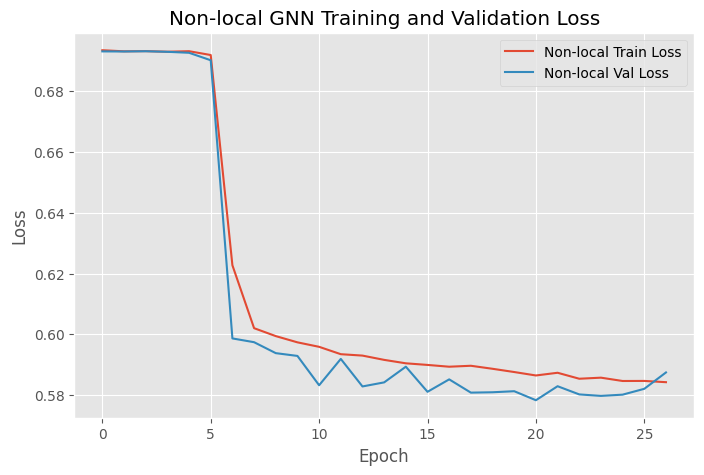

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(nonlocal_train_losses, label="Non-local Train Loss")
plt.plot(nonlocal_val_losses, label="Non-local Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Non-local GNN Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
model.eval()
baseline_labels = []
baseline_probs = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        probs = torch.softmax(out, dim=1)[:, 1]
        baseline_probs.extend(probs.cpu().numpy())
        baseline_labels.extend(data.y.cpu().numpy())
fpr_base, tpr_base, _ = roc_curve(baseline_labels, baseline_probs)
roc_auc_base = auc(fpr_base, tpr_base)


In [ ]:
nonlocal_model.eval()
nonlocal_labels = []
nonlocal_probs = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = nonlocal_model(data)
        probs = torch.softmax(out, dim=1)[:, 1]
        nonlocal_probs.extend(probs.cpu().numpy())
        nonlocal_labels.extend(data.y.cpu().numpy())
fpr_nonlocal, tpr_nonlocal, _ = roc_curve(nonlocal_labels, nonlocal_probs)
roc_auc_nonlocal = auc(fpr_nonlocal, tpr_nonlocal)


Baseline GNN ROC-AUC: 0.7546
Non-local GNN ROC-AUC: 0.7558


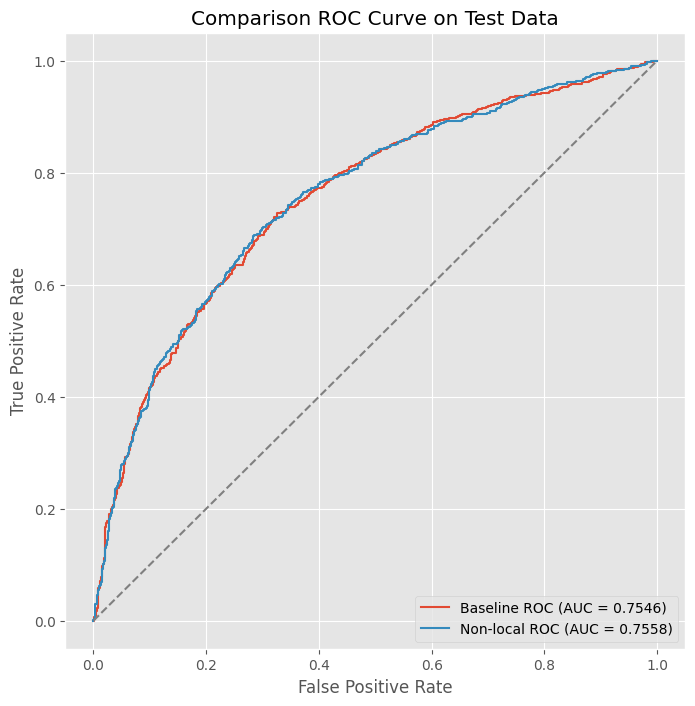

In [22]:
print(f"Baseline GNN ROC-AUC: {roc_auc_base:.4f}")
print(f"Non-local GNN ROC-AUC: {roc_auc_nonlocal:.4f}")

plt.figure(figsize=(8, 8))
plt.plot(fpr_base, tpr_base, label=f"Baseline ROC (AUC = {roc_auc_base:.4f})")
plt.plot(fpr_nonlocal, tpr_nonlocal, label=f"Non-local ROC (AUC = {roc_auc_nonlocal:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparison ROC Curve on Test Data")
plt.legend(loc="lower right")
plt.show()